# 📌 Machine Learning for False Signal Detection in Trading

## 📖 Overview
This project applies **Machine Learning (ML)** to **False Signal Detection** in trading. The goal is to enhance the **win rate** of a trading system by identifying **ineffective trade signals**. By leveraging **supervised learning** with models such as:

- **Decision Tree**
- **Random Forest**
- **Naïve Bayes**

The system learns from **historical trading signals**, **technical indicators**, and their **trade outcomes (profit/loss)** to detect unreliable signals that frequently lead to losses.

---

## 🎯 Objective
- Train ML models to **recognize losing trade patterns**.
- **Filter out false signals** before executing trades.
- Improve overall **trading performance and risk management**.

---

## 📊 Dataset & Features
The dataset consists of **historical data**,**technical indicators**,**trading signals** and **trade outcomes**.

### **🔹 Input Features:**
- **Technical Indicators:** Moving Averages for creating  Trading Signals
- **Trading Signals:** Buy/Sell signals generated by the system.
- **Historical Data:** Open, High, Low, Close, Volume (OHLCV).

### **🎯 Target Variable:**
- **Profit/Loss Classification:** Binary output (Win ✅ or Loss ❌)

---

## 🛠️ Machine Learning Models
Three supervised learning models are implemented:

### **🌳 Decision Tree**
- A tree-based model that learns decision rules from historical trades.
- Captures non-linear relationships and interpretable decision paths.

### **🌲 Random Forest**
- An ensemble of Decision Trees to reduce overfitting.
- Improves accuracy and generalization.

### **🧮 Naïve Bayes**
- Probabilistic classifier.
- Based on Conditional Probability.

---

## 🔄 Workflow
1. **Data Collection:** Gather market data trading signals, technical indicators, and trade results.**
   - Fetch Historical Data.
   - Calculate Exponentail Moving Average. ( Trading Indicator )
   - Create Trading Signals.
2. **Backtesting:**
   - Backtest Trading signals performance with vectorbt.
   - Observe trading journals to evaluate trading performance. 
2. **Data Preprocessing:**
   - Normalization features with Z-Score.
   - Split data into training & testing sets as a time series method.
3. **Feature Engineering:**
   - Use trading signals at each time period along with the trade outcomes (profit or loss) to construct a new table for feature engineering before training machine learning models.
   - Use the DecisionTree model to identify parameters that yield the highest Precision and F1 Score, respectively. These parameters are used to improve trading quality by using machine learning to filter profit/loss buy points and the corresponding sell points, based on historical data (excluding unseen data).
4. **Model Training:**
   - Train DecisionTree, RandomForest, and NaïveBayes models with training set.
   - Assume that every model can detect profit and loss.
5. **Fowardtest with unseen data ( test set ) :**
   - Forward-test technical indicators using signals generated from unseen data, including both the new technical indicators and the original signals from technical analysis.
   - Develop rules to filter out unreliable trade signals.
6. **Trading Performance Evaluation:**
   - Evaluate the trading performance on unseen data using technical indicators, decision tree, random forest, and naive bayes, and compare the results with the buy & hold strategy and benchmark.

---

## 📊 Performance Metrics
- **Precision**: Measures the proportion of correctly identified winning trades.
- **F1-Score**: Balances precision and recall.
- **Confusion Matrix**: Visualizes classification performance.

---

## 📌 Expected Outcome
✅ **Reduced False Trades:** Fewer trades based on unreliable signals.  
✅ **Improved Trading Win Rate:** More profitable trades and reduced unnecessary losses.  
✅ **Better Risk Management:** Avoiding bad trades reduces exposure to losses.  

---

## 🚀 Future Enhancements
🔹 Experiment with technical indicators, fundamental data, economic data, and other news data as well.
🔹 Incorporate **Deep Learning (LSTM, CNN)** for pattern recognition.  
🔹 Implement **Deep Reinforcement Learning** for strategy optimization.  
🔹 Experiment with additional **Feature Selection Techniques**.  

---

## 📜 Conclusion
By applying **Machine Learning to trading signals**, this project aims to enhance trading performance by filtering out **false signals**. The insights gained will contribute to **data-driven decision-making** and ultimately **higher profitability** in algorithmic trading.


<br>

<br>

<br>


### Import Libary

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


import time
from IPython.display import clear_output

import matplotlib.pyplot as plt
import plotly.graph_objs as go


from sklearn import tree
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, f1_score

import yfinance as yf
import pandas_ta as ta
import vectorbt as vbt

import warnings
warnings.filterwarnings('ignore')

<br>

<br>

### Building Necessary Function

##### Visualizasion Asset Compound Return

In [2]:
def visualizasion_portfolio_compound_return(port,label='',color='#3987b3'):
    port_value = port.value()
    port_compound_return = (port_value  / port_value.iloc[0]) - 1   #Calculate Compound Return of Trading Strategy
    
    index = port_compound_return.index
    value = port_compound_return.values

    # Visualizasion
    plt.figure(figsize=(10, 4))
    plt.plot(index, value*100, label=label,color=color)
    plt.show()

    return index ,value

##### Optimal Decision Tree for False Signal Detection

In [3]:
def find_optimal_tree_gain_profit_signals(X, y, X_train, y_train):
    results = []
    best_clf = None  # To store the best model

    for i in range(3, 50):  # Iterate through different values for `min_samples_leaf`
        clf = tree.DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=i)
        clf = clf.fit(X_train, y_train)

        all_predict = clf.predict(X)


        precision = precision_score(y, all_predict, average='binary')
        f1 = f1_score(y, all_predict, average='binary')

        results.append({
            'min_samples_leaf': i,
            'Precision': precision,
            'F1 Score': f1,
        })

        # Store the best model
        if best_clf is None or precision > max([r['Precision'] for r in results]):
            best_clf = clf

    results_df = pd.DataFrame(results)

    
    # Sort by Precision and F1 Score
    results_df = results_df.sort_values(by=['Precision','F1 Score'], ascending=False)

    display(results_df.head(10))
    print('\n'*5)

    # Plot Decision Tree of the best model
    plt.figure(figsize=(15, 7))
    tree.plot_tree(best_clf, feature_names=X.columns, class_names=['Loss', 'Profit'], filled=True)
    plt.show()

    return results_df

<br>

<br>

### Fetching Data

##### Initail Parameter

In [4]:
symbol = "BTC-USD"
interval = '1h'
periods = '2y'             

##### Fetch Historical Data

In [5]:
data = yf.download(symbol,interval=interval,period=periods)
df = data.copy()
df.columns = df.columns.droplevel(1)
df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Datetime,,,,,
2023-04-10 13:00:00+00:00,28196.224609,28298.953125,28189.271484,28285.896484,0
2023-04-10 14:00:00+00:00,28322.121094,28345.886719,28208.099609,28208.099609,82999296
2023-04-10 15:00:00+00:00,28458.748047,28550.707031,28316.855469,28316.855469,690993152
2023-04-10 16:00:00+00:00,29068.099609,29115.505859,28413.558594,28459.314453,1567852544
2023-04-10 17:00:00+00:00,29161.078125,29287.150391,29041.671875,29068.251953,2034193408
...,...,...,...,...,...
2025-04-10 09:00:00+00:00,82011.414062,82011.414062,81342.109375,81506.109375,0
2025-04-10 10:00:00+00:00,81698.382812,82086.093750,81563.789062,82008.109375,243310592
2025-04-10 11:00:00+00:00,81824.625000,81853.835938,81472.750000,81704.429688,0


<br>

<br>

<br>

### Create Technical Indicator

##### Initail Parameter

In [6]:
fast_ma = 10
slow_ma = 30

##### Calculate Indicator

In [7]:
df['fast_ma'] =  ta.ema(close=df['Close'],length= fast_ma)
df['slow_ma'] = ta.ema(close=df['Close'],length= slow_ma)
display(df.tail())

Price,Close,High,Low,Open,Volume,fast_ma,slow_ma
Datetime,,,,,,,
2025-04-10 09:00:00+00:00,82011.414062,82011.414062,81342.109375,81506.109375,0,81809.580769,80600.228938
2025-04-10 10:00:00+00:00,81698.382812,82086.093750,81563.789062,82008.109375,243310592,81789.362959,80671.077575
2025-04-10 11:00:00+00:00,81824.625000,81853.835938,81472.750000,81704.429688,0,81795.774239,80745.499990
2025-04-10 12:00:00+00:00,81632.070312,82338.937500,81435.890625,81835.203125,8435146752,81766.009889,80802.698075
2025-04-10 13:00:00+00:00,81584.023438,81660.328125,81499.796875,81660.328125,3387125760,81732.921443,80853.106163


<br>

<br>

<br>

### Backtest Trading Strategy

##### Make Decision Signal

In [8]:
df_signal = pd.DataFrame(index=df.index)
df_signal['Long_Entry'] = df['fast_ma'] > df['slow_ma']
df_signal['Long_Exit'] =  df['fast_ma'] < df['slow_ma']

df_signal.Long_Entry = df_signal.Long_Entry.shift(1).fillna(False)
df_signal.Long_Exit = df_signal.Long_Exit.shift(1).fillna(False)

##### Backtest

In [9]:
port = vbt.Portfolio.from_signals(open=df.Open,
                                  high=df.High,
                                  low=df.Low,
                                  close=df.Close,
                                  entries=df_signal['Long_Entry'], # Buy-Side Entry
                                  exits=df_signal['Long_Exit'],    # Buy-Side Exit
                                  direction='longonly',
                                  init_cash=1000,
                                  fees=0.001
                                 )
original_signal_stats = pd.DataFrame(port.stats(),columns=['Original Signal Stats'])
display(original_signal_stats)

,Original Signal Stats
Start,2023-04-10 13:00:00+00:00
End,2025-04-10 13:00:00+00:00
Period,17460
Start Value,1000.0
End Value,946.460317
Total Return [%],-5.353968
Benchmark Return [%],189.343785
Max Gross Exposure [%],100.0
Total Fees Paid,601.807322
Max Drawdown [%],37.263963


<br>

#### Visualizasion Trading Strategy Compound Return

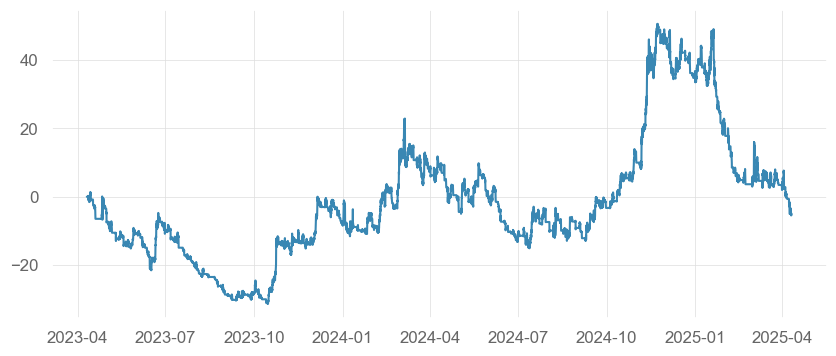

In [10]:
index ,value = visualizasion_portfolio_compound_return(port,label='All signal from Technical Analysis',color='#3987b3')

<br>

<br>

<br>

### Trading Journals 

In [11]:
trades = port.trades.records_readable

# Add 'fast_ma' and 'slow_ma' from the variables
trades['Fast_MA'] = df['fast_ma'].reindex(trades['Entry Timestamp']).values
trades['Slow_MA'] = df['slow_ma'].reindex(trades['Entry Timestamp']).values

trades['Close_pct_change_from_FastMA_Entry'] = trades['Avg Entry Price'] / trades['Fast_MA'] -1
trades['Close_pct_change_from_SlowMA_Entry'] = trades['Avg Entry Price'] / trades['Slow_MA'] -1

trades['Close_pct_change_from_FastMA_Exit'] = trades['Avg Exit Price'] / trades['Fast_MA'] -1
trades['Close_pct_change_from_SlowMA_Exit'] = trades['Avg Exit Price'] / trades['Slow_MA'] -1

# Calculate 'ProfitFromSignals' after the MA columns are added
trades['ProfitFromSignals'] = np.sign(trades['Return'])

# Display the updated trades DataFrame
display(trades.head(5))

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,...,Direction,Status,Position Id,Fast_MA,Slow_MA,Close_pct_change_from_FastMA_Entry,Close_pct_change_from_SlowMA_Entry,Close_pct_change_from_FastMA_Exit,Close_pct_change_from_SlowMA_Exit,ProfitFromSignals
0,0,0,0.033113,2023-04-11 19:00:00+00:00,30169.523438,0.999001,2023-04-12 23:00:00+00:00,29892.160156,0.989817,-11.173126,...,Long,Closed,0,30154.248933,29749.111505,0.000507,0.014132,-0.008692,0.004809,-1.0
1,1,0,0.032776,2023-04-13 02:00:00+00:00,30138.958984,0.987839,2023-04-14 18:00:00+00:00,30294.535156,0.992938,3.118411,...,Long,Closed,1,30010.206318,29980.361689,0.004290,0.005290,0.009474,0.010479,1.0
2,2,0,0.032654,2023-04-16 22:00:00+00:00,30347.251953,0.990954,2023-04-17 00:00:00+00:00,29864.736328,0.975198,-17.722141,...,Long,Closed,2,30345.173362,30342.076163,0.000068,0.000171,-0.015832,-0.015732,-1.0
3,3,0,0.032039,2023-04-18 11:00:00+00:00,30376.947266,0.973250,2023-04-19 09:00:00+00:00,29221.488281,0.936230,-38.929340,...,Long,Closed,3,29822.914587,29742.962724,0.018577,0.021315,-0.020167,-0.017533,-1.0
4,4,0,0.033365,2023-04-25 20:00:00+00:00,28003.892578,0.934359,2023-04-28 15:00:00+00:00,29153.964844,0.972732,36.465463,...,Long,Closed,4,27568.234541,27493.342816,0.015803,0.018570,0.057520,0.060401,1.0


<br>

<br>

<br>

### Data Manipulation & Pre-Processing

<br>

#### Assign Entry & Exit Timestamp

In [12]:
entry_ts = trades[['Entry Timestamp']]
exit_ts = trades[['Exit Timestamp']]

<br>

#### Calculate Split Test Set index ( Time Series )
##### To Ensure that Machine Learning Models can test with Actually Unseen Data

In [13]:
pct_split = 70
start_test_position = int(len(trades)*pct_split/100)
print('Percentage :',pct_split,' %')
print('Start Index :',start_test_position)

Percentage : 70  %
Start Index : 217


<br>

<br>

#### Pre-Processing

In [14]:
X = trades[['Close_pct_change_from_FastMA_Entry','Close_pct_change_from_SlowMA_Entry','Close_pct_change_from_FastMA_Exit','Close_pct_change_from_SlowMA_Exit']]
y = trades[['ProfitFromSignals']]

In [15]:
display(X.tail())

,Close_pct_change_from_FastMA_Entry,Close_pct_change_from_SlowMA_Entry,Close_pct_change_from_FastMA_Exit,Close_pct_change_from_SlowMA_Exit
306,-0.005809,-0.006468,-0.002575,-0.003236
307,0.005723,0.007890,-0.005805,-0.003663
308,-0.001442,-0.001476,-0.003174,-0.003208
309,0.019274,0.022142,-0.023378,-0.020630
310,0.038403,0.049580,0.035403,0.046547


In [16]:
display(y.tail())

,ProfitFromSignals
306,1.0
307,-1.0
308,-1.0
309,-1.0
310,-1.0


<br>


#### Train & Test Split ( As a TimeSeries )

In [17]:
X_train = X.iloc[:start_test_position]
X_test = X.iloc[start_test_position:]
y_train = y.iloc[:start_test_position]
y_test = y.iloc[start_test_position:]

<br>

<br>

<br>

### Find Optimal min_samples_leaf of Decision Tree

,min_samples_leaf,Precision,F1 Score
0,3,0.950000,0.944099
1,4,0.950000,0.944099
17,20,0.944444,0.888889
15,18,0.933333,0.897436
16,19,0.933333,0.897436
13,16,0.922078,0.898734
14,17,0.922078,0.898734
2,5,0.904762,0.921212
5,8,0.904762,0.921212
8,11,0.904762,0.921212


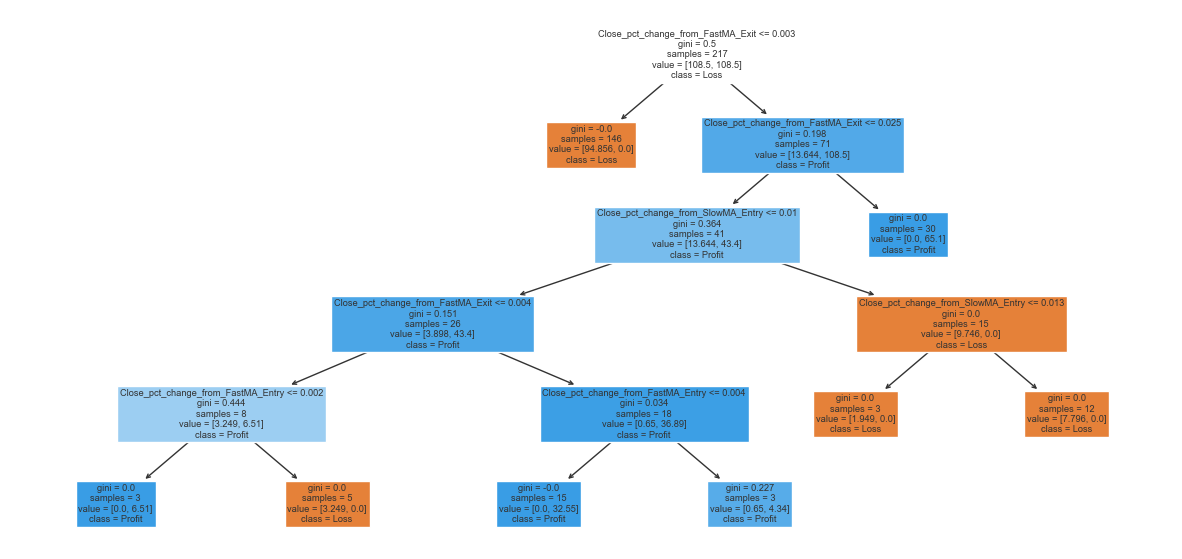

In [18]:
# Call the function
optimal_tree_results = find_optimal_tree_gain_profit_signals(X, y, X_train, y_train)

<br>

#### Best min sample for each leaf 

In [19]:
best_min_simples_leaf = int(optimal_tree_results[['min_samples_leaf']].iloc[0])
print(f'Optimal Precision Score in Training Set is {best_min_simples_leaf} data points for each leaf as a minimum')

Optimal Precision Score in Training Set is 3 data points for each leaf as a minimum


<br>

<br>

<br>

<br>

### Model Creation

#### Decision Tree

In [20]:
dt = tree.DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=best_min_simples_leaf)
dt = dt.fit(X_train, y_train)

#### Random Forest

In [21]:
rf = RandomForestClassifier( class_weight='balanced',min_samples_leaf=best_min_simples_leaf, n_estimators=100)
rf = rf.fit(X_train,y_train)

#### Naive Bayes

In [22]:
nb = GaussianNB()
nb = nb.fit(X_train,y_train)

<br>

### Test with only Unseen Data

#### Get Trade Logs

##### Independent Variable

In [23]:
X_test.index = trades.loc[X_test.index, 'Entry Timestamp']
display(X_test.head())

,Close_pct_change_from_FastMA_Entry,Close_pct_change_from_SlowMA_Entry,Close_pct_change_from_FastMA_Exit,Close_pct_change_from_SlowMA_Exit
Entry Timestamp,,,,
2024-08-08 04:00:00+00:00,0.007902,0.010357,0.067750,0.070351
2024-08-13 03:00:00+00:00,-0.004812,-0.005373,-0.001222,-0.001785
2024-08-13 16:00:00+00:00,0.025845,0.029782,-0.007596,-0.003788
2024-08-16 18:00:00+00:00,0.014315,0.017133,-0.004020,-0.001253
2024-08-19 23:00:00+00:00,0.008152,0.009909,0.004520,0.006270


##### Target Variable

In [24]:
y_test.index = trades.loc[y_test.index, 'Entry Timestamp']
display(y_test.head())

,ProfitFromSignals
Entry Timestamp,
2024-08-08 04:00:00+00:00,1.0
2024-08-13 03:00:00+00:00,1.0
2024-08-13 16:00:00+00:00,-1.0
2024-08-16 18:00:00+00:00,-1.0
2024-08-19 23:00:00+00:00,-1.0


<br>

##### Filter the dates in the main DataFrame  ( match the dates in the Test Set )

In [25]:
# Get the index value of the first row in X_test
start_index_value = X_test.index[0]

# Find the position of that index in df
start_index_pos = df.index.get_loc(start_index_value)

# Create a new DataFrame starting from the previous row
df_test = df.iloc[start_index_pos-1:]

# Display the new DataFrame
display(df_test)

Price,Close,High,Low,Open,Volume,fast_ma,slow_ma
Datetime,,,,,,,
2024-08-08 03:00:00+00:00,57142.472656,57586.734375,57142.472656,57372.574219,0,56232.529072,56154.460428
2024-08-08 04:00:00+00:00,56776.597656,57216.976562,56717.710938,57096.890625,0,56331.450633,56194.598314
2024-08-08 05:00:00+00:00,56989.269531,57025.343750,56772.234375,56772.234375,0,56451.054069,56245.867425
2024-08-08 06:00:00+00:00,57269.757812,57276.128906,56862.113281,56996.187500,0,56599.909295,56311.924869
2024-08-08 07:00:00+00:00,57213.132812,57417.019531,57213.132812,57252.054688,18202624,56711.404480,56370.067317
...,...,...,...,...,...,...,...
2025-04-10 09:00:00+00:00,82011.414062,82011.414062,81342.109375,81506.109375,0,81809.580769,80600.228938
2025-04-10 10:00:00+00:00,81698.382812,82086.093750,81563.789062,82008.109375,243310592,81789.362959,80671.077575
2025-04-10 11:00:00+00:00,81824.625000,81853.835938,81472.750000,81704.429688,0,81795.774239,80745.499990


<br>

<br>


### Predict the Unseen data

In [26]:
print('X_Test Index == y_test Index  :',(X_test.index == y_test.index).all(),'\n\n')

# Make predictions
y_pred_dt = dt.predict(X_test)
y_pred_dt = pd.DataFrame(y_pred_dt, columns=["ML_Signal_DT"], index=X_test.index)

y_pred_nb = nb.predict(X_test)
y_pred_nb = pd.DataFrame(y_pred_nb, columns=["ML_Signal_NB"], index=X_test.index)

y_pred_rf = rf.predict(X_test)
y_pred_rf = pd.DataFrame(y_pred_rf, columns=["ML_Signal_RF"], index=X_test.index)

# Combine the results
combined_df = pd.concat([X_test, y_test, y_pred_dt, y_pred_nb, y_pred_rf], axis=1)
display(combined_df)

X_Test Index == y_test Index  : True 




,Close_pct_change_from_FastMA_Entry,Close_pct_change_from_SlowMA_Entry,Close_pct_change_from_FastMA_Exit,Close_pct_change_from_SlowMA_Exit,ProfitFromSignals,ML_Signal_DT,ML_Signal_NB,ML_Signal_RF
Entry Timestamp,,,,,,,,
2024-08-08 04:00:00+00:00,0.007902,0.010357,0.067750,0.070351,1.0,1.0,1.0,1.0
2024-08-13 03:00:00+00:00,-0.004812,-0.005373,-0.001222,-0.001785,1.0,-1.0,-1.0,-1.0
2024-08-13 16:00:00+00:00,0.025845,0.029782,-0.007596,-0.003788,-1.0,-1.0,-1.0,-1.0
2024-08-16 18:00:00+00:00,0.014315,0.017133,-0.004020,-0.001253,-1.0,-1.0,-1.0,-1.0
2024-08-19 23:00:00+00:00,0.008152,0.009909,0.004520,0.006270,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...
2025-04-04 14:00:00+00:00,-0.005809,-0.006468,-0.002575,-0.003236,1.0,-1.0,-1.0,-1.0
2025-04-04 18:00:00+00:00,0.005723,0.007890,-0.005805,-0.003663,-1.0,-1.0,-1.0,-1.0
2025-04-06 06:00:00+00:00,-0.001442,-0.001476,-0.003174,-0.003208,-1.0,-1.0,-1.0,-1.0


<br>

<br>

### Reattach the indicators and trading signals to the DataFrame.

In [27]:
df_test = pd.concat([df_test, combined_df['ML_Signal_DT'],combined_df['ML_Signal_NB'],combined_df['ML_Signal_RF']], axis=1)
display(df_test)

,Close,High,Low,Open,Volume,fast_ma,slow_ma,ML_Signal_DT,ML_Signal_NB,ML_Signal_RF
2024-08-08 03:00:00+00:00,57142.472656,57586.734375,57142.472656,57372.574219,0,56232.529072,56154.460428,NaN,NaN,NaN
2024-08-08 04:00:00+00:00,56776.597656,57216.976562,56717.710938,57096.890625,0,56331.450633,56194.598314,1.0,1.0,1.0
2024-08-08 05:00:00+00:00,56989.269531,57025.343750,56772.234375,56772.234375,0,56451.054069,56245.867425,NaN,NaN,NaN
2024-08-08 06:00:00+00:00,57269.757812,57276.128906,56862.113281,56996.187500,0,56599.909295,56311.924869,NaN,NaN,NaN
2024-08-08 07:00:00+00:00,57213.132812,57417.019531,57213.132812,57252.054688,18202624,56711.404480,56370.067317,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-04-10 09:00:00+00:00,82011.414062,82011.414062,81342.109375,81506.109375,0,81809.580769,80600.228938,NaN,NaN,NaN
2025-04-10 10:00:00+00:00,81698.382812,82086.093750,81563.789062,82008.109375,243310592,81789.362959,80671.077575,NaN,NaN,NaN
2025-04-10 11:00:00+00:00,81824.625000,81853.835938,81472.750000,81704.429688,0,81795.774239,80745.499990,NaN,NaN,NaN
2025-04-10 12:00:00+00:00,81632.070312,82338.937500,81435.890625,81835.203125,8435146752,81766.009889,80802.698075,NaN,NaN,NaN


<br>

<br>

### Final Backtest All Trading Strategy ( With Unseen Data / Test Set ) 

<br>

<br>

#### Technical Indicator

In [28]:
df_signal = pd.DataFrame(index=df_test.index)
df_signal['Long_Entry'] = df_test['fast_ma'] > df_test['slow_ma']
df_signal['Long_Exit'] =  df_test['fast_ma'] < df_test['slow_ma']

df_signal.Long_Entry = df_signal.Long_Entry.shift(1).fillna(False)
df_signal.Long_Exit = df_signal.Long_Exit.shift(1).fillna(False)

In [29]:
port = vbt.Portfolio.from_signals(open=df_test.Open,
                                  high=df_test.High,
                                  low=df_test.Low,
                                  close=df_test.Close,
                                  entries=df_signal['Long_Entry'], # Buy-Side Entry
                                  exits=df_signal['Long_Exit'],    # Buy-Side Exit
                                  direction='longonly',
                                  init_cash=1000,
                                  fees=0.001
                                 )
original_signal_stats = pd.DataFrame(port.stats(),columns=['Original Signal Stats'])
display(original_signal_stats)

,Original Signal Stats
Start,2024-08-08 03:00:00+00:00
End,2025-04-10 13:00:00+00:00
Period,5890
Start Value,1000.0
End Value,1074.636541
Total Return [%],7.463654
Benchmark Return [%],42.773002
Max Gross Exposure [%],100.0
Total Fees Paid,242.566338
Max Drawdown [%],37.263963


#### Visualizasion Trading Strategy ( with Only Technical Analysis ) Compound Return

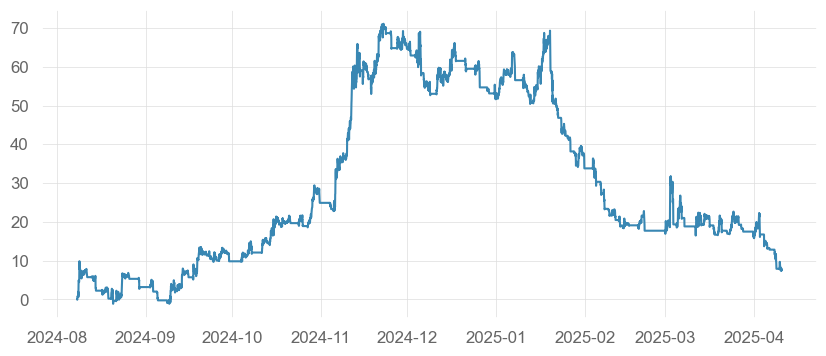

In [30]:
index_ta ,value_ta = visualizasion_portfolio_compound_return(port,label='Original Signal Stats',color='#3987b3')

<br>

<br>


#### Decision Tree 

In [31]:
dt_signal = pd.DataFrame(index=df_test.index)

dt_signal['Long_Entry'] = (df_test['ML_Signal_DT'] == 1)
dt_signal['Long_Exit'] = (df_test['ML_Signal_DT'] == -1)

dt_signal['Long_Entry'] = dt_signal['Long_Entry'].shift(1).fillna(False) 
dt_signal['Long_Exit'] = dt_signal['Long_Exit'].shift(1).fillna(False)

In [32]:
# Step 4: ทำ Backtest ด้วย vectorbt โดยใช้สัญญาณ Entry และ Exit ที่ได้
port_dt = vbt.Portfolio.from_signals(
    open=df_test['Open'],  
    high=df_test['High'],
    low=df_test['Low'],
    close=df_test['Close'],
    entries=dt_signal['Long_Entry'],
    exits=dt_signal['Long_Exit'],
    direction='longonly',
    init_cash=1000,
    fees=0.001,
)

dt_portfolio_stats = pd.DataFrame(port_dt.stats(), columns=['DT Portfolio Stats'])
display(dt_portfolio_stats)

,DT Portfolio Stats
Start,2024-08-08 03:00:00+00:00
End,2025-04-10 13:00:00+00:00
Period,5890
Start Value,1000.0
End Value,2411.830266
Total Return [%],141.183027
Benchmark Return [%],42.773002
Max Gross Exposure [%],100.0
Total Fees Paid,69.573003
Max Drawdown [%],14.23469


#### Visualization of Decision Tree & Trading Strategy (False Signal Detection) Compound Return

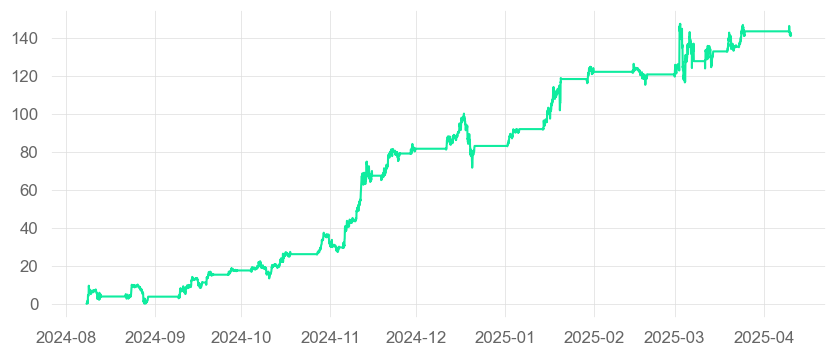

In [33]:
index_dt ,value_dt = visualizasion_portfolio_compound_return(port_dt,label='TA with Decision Tree False Signal Detection', color='#0fec9f')

<br>


#### Naive Bayes

In [34]:
nb_signal = pd.DataFrame(index=df_test.index)

nb_signal['Long_Entry'] = (df_test['ML_Signal_NB'] == 1)
nb_signal['Long_Exit'] = (df_test['ML_Signal_NB'] == -1)

nb_signal['Long_Entry'] = nb_signal['Long_Entry'].shift(1).fillna(False) 
nb_signal['Long_Exit'] = nb_signal['Long_Exit'].shift(1).fillna(False)

In [35]:
port_nb = vbt.Portfolio.from_signals(
    open=df_test['Open'], 
    high=df_test['High'],
    low=df_test['Low'],
    close=df_test['Close'],
    entries=nb_signal['Long_Entry'],
    exits=nb_signal['Long_Exit'],
    direction='longonly',
    init_cash=1000,
    fees=0.001
)

nb_portfolio_stats = pd.DataFrame(port_nb.stats(), columns=['NB Portfolio Stats'])
display(nb_portfolio_stats)

,NB Portfolio Stats
Start,2024-08-08 03:00:00+00:00
End,2025-04-10 13:00:00+00:00
Period,5890
Start Value,1000.0
End Value,2298.931846
Total Return [%],129.893185
Benchmark Return [%],42.773002
Max Gross Exposure [%],100.0
Total Fees Paid,57.287156
Max Drawdown [%],14.23469


#### Visualization of Naive Bayes & Trading Strategy (False Signal Detection) Compound Return

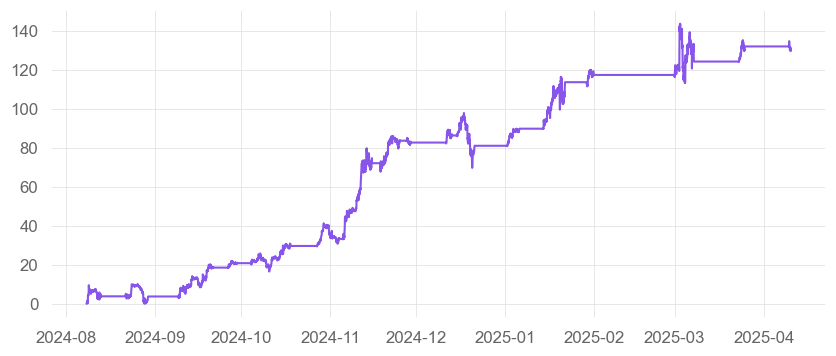

In [36]:
index_nb ,value_nb = visualizasion_portfolio_compound_return(port_nb,label='TA with NaiveBayes False Signal Detection', color='#8755ea')

<br>

#### Random Forest 

In [37]:
rf_signal = pd.DataFrame(index=df_test.index)

rf_signal['Long_Entry'] = (df_test['ML_Signal_RF'] == 1)
rf_signal['Long_Exit'] = (df_test['ML_Signal_RF'] == -1)

rf_signal['Long_Entry'] = rf_signal['Long_Entry'].shift(1).fillna(False)  # Shift เพื่อให้สัญญาณเกิดขึ้นหลังจากเกิดสภาวะ
rf_signal['Long_Exit'] = rf_signal['Long_Exit'].shift(1).fillna(False)

In [38]:
port_rf = vbt.Portfolio.from_signals(
    open=df_test['Open'],
    high=df_test['High'],
    low=df_test['Low'],
    close=df_test['Close'],
    entries=rf_signal['Long_Entry'],
    exits=rf_signal['Long_Exit'],
    direction='longonly',
    init_cash=1000,
    fees=0.001
)

rf_portfolio_stats = pd.DataFrame(port_rf.stats(), columns=['RF Portfolio Stats'])
display(rf_portfolio_stats)

,RF Portfolio Stats
Start,2024-08-08 03:00:00+00:00
End,2025-04-10 13:00:00+00:00
Period,5890
Start Value,1000.0
End Value,2500.941587
Total Return [%],150.094159
Benchmark Return [%],42.773002
Max Gross Exposure [%],100.0
Total Fees Paid,68.99591
Max Drawdown [%],14.23469


#### Visualization of Random Forest & Trading Strategy (False Signal Detection) Compound Return

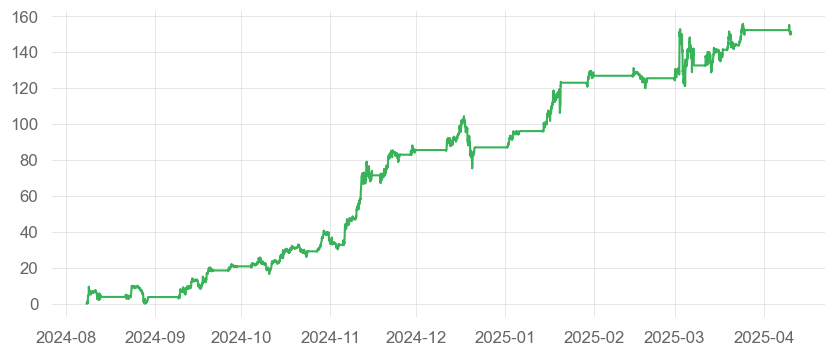

In [39]:
index_rf ,value_rf = visualizasion_portfolio_compound_return(port_rf,label='TA with RandomForest False Signal Detection', color='#39b359')

<br>

#### Visualization of Benchmark Compound Return

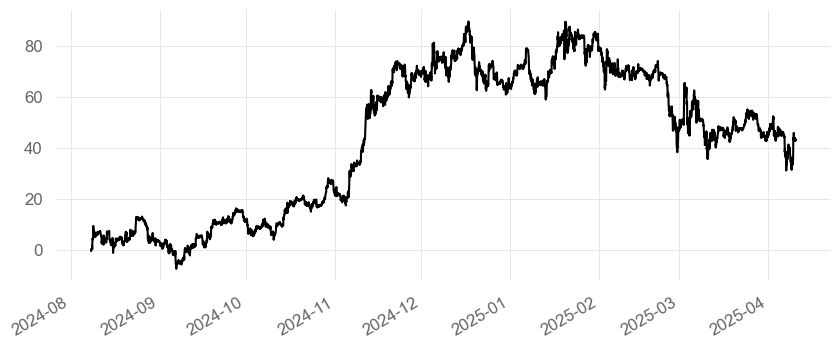

In [40]:
benchmark = df_test[['Close']][:]
benchmark_compound_return = (1+ benchmark.pct_change()).cumprod()-1
(benchmark_compound_return * 100).plot(figsize=(10, 4),color='black',legend=False)
plt.show()

<br>

<br>

<br>

### Performance Evaluation ( Unseen data )

<br>

#### DataFrame

In [41]:
display(pd.concat([original_signal_stats,dt_portfolio_stats,rf_portfolio_stats,nb_portfolio_stats],axis=1))

,Original Signal Stats,DT Portfolio Stats,RF Portfolio Stats,NB Portfolio Stats
Start,2024-08-08 03:00:00+00:00,2024-08-08 03:00:00+00:00,2024-08-08 03:00:00+00:00,2024-08-08 03:00:00+00:00
End,2025-04-10 13:00:00+00:00,2025-04-10 13:00:00+00:00,2025-04-10 13:00:00+00:00,2025-04-10 13:00:00+00:00
Period,5890,5890,5890,5890
Start Value,1000.0,1000.0,1000.0,1000.0
End Value,1074.636541,2411.830266,2500.941587,2298.931846
Total Return [%],7.463654,141.183027,150.094159,129.893185
Benchmark Return [%],42.773002,42.773002,42.773002,42.773002
Max Gross Exposure [%],100.0,100.0,100.0,100.0
Total Fees Paid,242.566338,69.573003,68.99591,57.287156
Max Drawdown [%],37.263963,14.23469,14.23469,14.23469


<br>

#### Visualization 

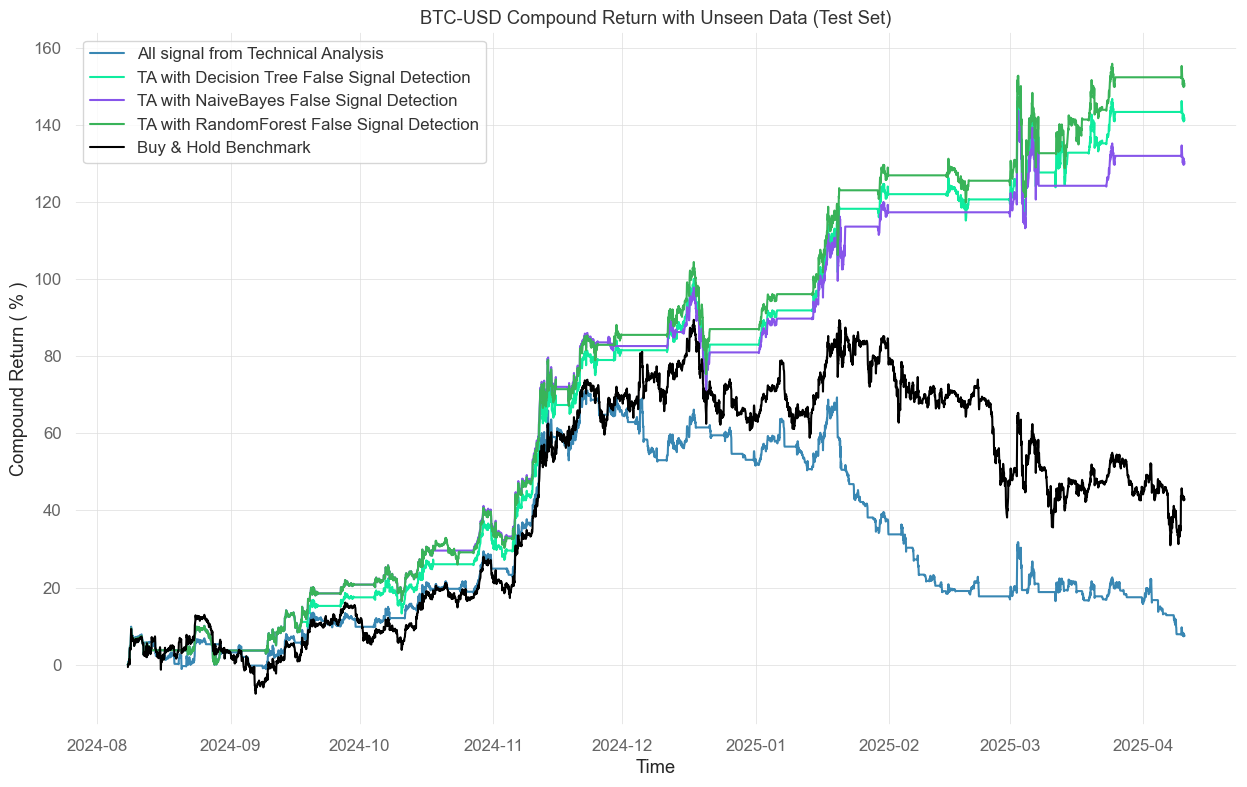

In [42]:
multiplier = 100

# Plot the compound return over time for both portfolios
plt.figure(figsize=(15, 9))

# Plot Technical Indicator Compound Return 
plt.plot(index_ta, value_ta*multiplier, label='All signal from Technical Analysis',color='#3987b3')

# Plot the ML Compound Return 
plt.plot(index_dt, value_dt*multiplier, label='TA with Decision Tree False Signal Detection', color='#0fec9f')

# Plot the ML Compound Return 
plt.plot(index_nb, value_nb*multiplier, label='TA with NaiveBayes False Signal Detection', color='#8755ea')

# Plot the ML Compound Return 
plt.plot(index_rf, value_rf*multiplier, label='TA with RandomForest False Signal Detection', color='#39b359')

plt.plot(benchmark_compound_return.index,benchmark_compound_return.values*multiplier, label='Buy & Hold Benchmark',color='black')

# Add labels and title
plt.title(f'{symbol} Compound Return with Unseen Data (Test Set)')
plt.xlabel('Time')
plt.ylabel('Compound Return ( % )')

# Add a legend to differentiate between the two portfolios
plt.legend()

# Add gridlines 
plt.grid(True)

# Show the plot
plt.show()